In [1]:
# test_phase_3_corrected.ipynb

import torch
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Import all library components ---
from neural_mi.data.processors import ContinuousProcessor
from neural_mi.models.embeddings import MLP
from neural_mi.models.critics import SeparableCritic
from neural_mi.training.trainer import Trainer
from neural_mi.estimators import bounds # <-- Import the bounds module

# --- Setup ---
device = 'cpu'
print(f"--- Testing Phase 3 (Corrected Trainer) on {device} ---")

# --- 1. Generate and Process Data ---
N_SAMPLES = 4000
N_CHANNELS = 10
WINDOW_SIZE = 100
STEP_SIZE = 20

base_signal = np.random.randn(1, N_SAMPLES)
x_raw = np.repeat(base_signal, N_CHANNELS, axis=0) + np.random.randn(N_CHANNELS, N_SAMPLES) * 0.5
y_raw = np.repeat(base_signal, N_CHANNELS, axis=0) + np.random.randn(N_CHANNELS, N_SAMPLES) * 0.5

cont_proc = ContinuousProcessor(window_size=WINDOW_SIZE, step_size=STEP_SIZE)
x_data = cont_proc.process(x_raw).to(device)
y_data = cont_proc.process(y_raw).to(device)
print(f"Created processed data with shape: {x_data.shape}")
print("-" * 30)

--- Testing Phase 3 (Corrected Trainer) on cpu ---
Created processed data with shape: torch.Size([196, 10, 100])
------------------------------


In [23]:
# --- 2. Build Model and Optimizer ---
INPUT_DIM = x_data.shape[1] * x_data.shape[2]
critic = SeparableCritic(
    embedding_net_x=MLP(INPUT_DIM, 256, 64, 3),
    embedding_net_y=MLP(INPUT_DIM, 256, 64, 3)
)
optimizer = optim.Adam(critic.parameters(), lr=1e-4)
print("Model and optimizer created.")
print("-" * 30)

Model and optimizer created.
------------------------------


In [24]:
# --- 3. Instantiate and Run the Corrected Trainer ---
N_EPOCHS = 200
BATCH_SIZE = 256
PATIENCE = 8
MODEL_SAVE_PATH = "my_best_mi_model.pt"

# --- KEY CHANGE: Pass the MI bound function to the Trainer ---
trainer = Trainer(
    model=critic,
    estimator_fn=bounds.infonce_lower_bound, # <-- Pass the estimator function here
    optimizer=optimizer
)

print("Starting corrected training...")
results = trainer.train(
    x_data=x_data,
    y_data=y_data,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE,
    sigma=1.0,
    median_window=5,
    save_best_model_path=MODEL_SAVE_PATH
)
print("Training finished.")
print("-" * 30)

Starting corrected training...
Epoch 1/200 | Test MI: 0.0142
Epoch 2/200 | Test MI: 0.0160
Epoch 3/200 | Test MI: 0.0178
Epoch 4/200 | Test MI: 0.0197
Epoch 5/200 | Test MI: 0.0217
Epoch 6/200 | Test MI: 0.0237
Epoch 7/200 | Test MI: 0.0257
Epoch 8/200 | Test MI: 0.0278
Epoch 9/200 | Test MI: 0.0300
Epoch 10/200 | Test MI: 0.0321
Epoch 11/200 | Test MI: 0.0341
Epoch 12/200 | Test MI: 0.0362
Epoch 13/200 | Test MI: 0.0385
Epoch 14/200 | Test MI: 0.0408
Epoch 15/200 | Test MI: 0.0433
Epoch 16/200 | Test MI: 0.0460
Epoch 17/200 | Test MI: 0.0489
Epoch 18/200 | Test MI: 0.0514
Epoch 19/200 | Test MI: 0.0540
Epoch 20/200 | Test MI: 0.0567
Epoch 21/200 | Test MI: 0.0593
Epoch 22/200 | Test MI: 0.0619
Epoch 23/200 | Test MI: 0.0647
Epoch 24/200 | Test MI: 0.0676
Epoch 25/200 | Test MI: 0.0706
Epoch 26/200 | Test MI: 0.0737
Epoch 27/200 | Test MI: 0.0768
Epoch 28/200 | Test MI: 0.0798
Epoch 29/200 | Test MI: 0.0826
Epoch 30/200 | Test MI: 0.0853
Epoch 31/200 | Test MI: 0.0879
Epoch 32/200 | Te

Verifying results...
Final Train MI (from best model): 0.9706
Final Test MI (from best model): 0.1133
Best model successfully saved to 'my_best_mi_model.pt'
Cleaned up saved model file.


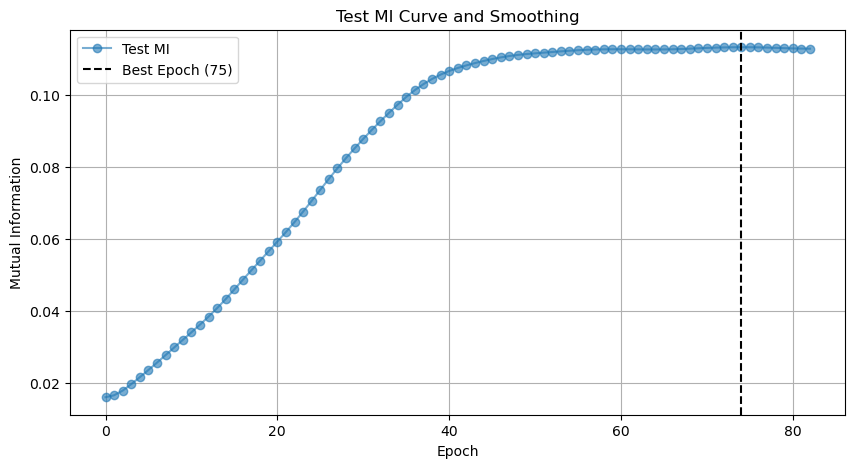


✅ Phase 3 (Corrected) test completed successfully!


In [25]:
# --- 4. Verify Results ---
print("Verifying results...")
assert 'train_mi' in results and results['train_mi'] is not None
assert 'test_mi' in results and results['test_mi'] is not None
assert results['train_mi'] > 0, "Final Train MI should be positive"
assert results['test_mi'] > 0, "Final Test MI should be positive"
print(f"Final Train MI (from best model): {results['train_mi']:.4f}")
print(f"Final Test MI (from best model): {results['test_mi']:.4f}")
assert os.path.exists(MODEL_SAVE_PATH), "Best model was not saved!"
print(f"Best model successfully saved to '{MODEL_SAVE_PATH}'")
os.remove(MODEL_SAVE_PATH)
print("Cleaned up saved model file.")

# Visualize the test curve
plt.figure(figsize=(10, 5))
plt.plot(results['test_mi_history'], 'o-', label='Test MI', alpha=0.6)
plt.axvline(x=results['best_epoch'], color='k', linestyle='--', label=f'Best Epoch ({results["best_epoch"]+1})')
plt.title("Test MI Curve and Smoothing")
plt.xlabel("Epoch")
plt.ylabel("Mutual Information")
plt.legend()
plt.grid(True)
plt.show()

print("\n✅ Phase 3 (Corrected) test completed successfully!")

In [27]:
results

{'train_mi': 0.9706325531005859,
 'test_mi': 0.1133413314819336,
 'best_epoch': np.int64(74),
 'test_mi_history': array([0.01611871, 0.01665963, 0.01795886, 0.01975339, 0.02169809,
        0.02369058, 0.02573444, 0.02783354, 0.02995016, 0.03204715,
        0.03414233, 0.0362863 , 0.03851961, 0.04087647, 0.04339907,
        0.04606949, 0.04877434, 0.05142466, 0.05405834, 0.05670216,
        0.05933333, 0.06198747, 0.06475559, 0.06766064, 0.07066371,
        0.07372421, 0.07676864, 0.079716  , 0.08254022, 0.08524941,
        0.08785778, 0.09036784, 0.09277625, 0.09510655, 0.09736783,
        0.09949063, 0.10139172, 0.10304715, 0.10448132, 0.10570709,
        0.10671933, 0.10755024, 0.10826212, 0.10890325, 0.10949151,
        0.1100193 , 0.11047878, 0.11086616, 0.11117596, 0.1114141 ,
        0.11161168, 0.11179919, 0.1119821 , 0.1121596 , 0.1123315 ,
        0.11248308, 0.11259816, 0.1126761 , 0.11272149, 0.11273947,
        0.11274127, 0.11273126, 0.11271092, 0.11269355, 0.11268861,
   